# International Stock Market Visualization

In [2]:
import math
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta, FR

from bokeh.plotting import figure, show
from bokeh.models import TickFormatter, MultiSelect, CustomJS, ColumnDataSource, HoverTool
from bokeh.layouts import row
from bokeh.palettes import Category10, Category20, Category20b, Category20c
from bokeh.util.compiler import TypeScript
from bokeh.io import output_notebook
output_notebook()

import pandas as pd
pd.set_option('display.max_rows', 100) 

import os
import numpy as np
import sqlite3 as sl
from sqlite3 import Error

import json
import csv
from io import StringIO
import matplotlib.pyplot as plt

import requests
from requests.structures import CaseInsensitiveDict
import urllib.parse

import quandl
secrets = json.load(open("secrets.json", "r"))
quandl.ApiConfig.api_key = secrets["nasdaq-quandl"]["api-key"]


Loading BokehJS ...

## Create database if not exists
To avoid too much queries and unnecessary data updates, we create/load a database.
We define that we are only interested in the data until last Friday.

In [3]:
start_date = datetime(2010, 1, 1)
last_date = start_date
date_of_last_friday = datetime.now() + relativedelta(weekday=FR(-1))
print("last friday is", date_of_last_friday.isoformat(timespec='milliseconds'))

db_abs_path = os.path.abspath('international_data.db')
db_conn = sl.connect(db_abs_path)

# create table 'currency' if not exists
db_conn.execute("""create table if not exists currency 
            (date DATE, USD_EUR FLOAT, USD_CNY FLOAT, USD_JPY FLOAT, USD_GBP FLOAT,
            PRIMARY KEY (date))""")

# create table 'commodity' if not exists
db_conn.execute("""create table if not exists commodity 
            (date DATE, OIL FLOAT, GOLD FLOAT, SILVER FLOAT,
            PRIMARY KEY (date))""")

last friday is 2023-05-19T22:05:38.406


## Get currency history
Get exchange rates until last Friday.
https://app.freecurrencyapi.com/request-playground

In [5]:
currency_df = pd.read_sql_query("SELECT * FROM currency", db_conn)
if len(currency_df.index)>0:
    dates = pd.to_datetime(currency_df['date'])
    last_date = dates.max()

if last_date < date_of_last_friday:
    api_key = secrets["freecurrencyapi"]["api-key"]

    delta_in_s = (date_of_last_friday - last_date).total_seconds()
    years = int(divmod(delta_in_s, 31536000)[0])

    if years > 0:
        print(f"delta is too large: {years}. we split the timeslot to years.")
        for i in range(years):
            url = f"https://api.freecurrencyapi.com/v1/historical?apikey={api_key}&currencies=EUR%2CCNY%2CJPY%2CGBP&"+ \
            f"date_from={urllib.parse.quote((last_date + relativedelta(years=i)).isoformat(timespec='milliseconds'))}Z&"+ \
            f"date_to={urllib.parse.quote((last_date + relativedelta(years=i+1)).isoformat(timespec='milliseconds'))}Z"

            resp = requests.get(url)
            if resp.status_code == 200:
                data = json.loads(resp.content)["data"]
                
                for key, value in data.items():
                    row = pd.DataFrame({'date': [key], 'USD_EUR': [value["EUR"]], "USD_CNY": [value["CNY"]], "USD_JPY": [value["JPY"]], "USD_GBP": [value["GBP"]]})
                    currency_df = pd.concat([currency_df, row], ignore_index=True)
        last_date = last_date + relativedelta(years=years)
    
    url = f"https://api.freecurrencyapi.com/v1/historical?apikey={api_key}&currencies=EUR%2CCNY%2CJPY%2CGBP&"+\
        f"date_from={urllib.parse.quote(last_date.isoformat(timespec='milliseconds'))}Z&date_to={urllib.parse.quote(date_of_last_friday.isoformat(timespec='milliseconds'))}Z"
    print(url)
    resp = requests.get(url)
    if resp.status_code == 200:
        print("success")
        data = json.loads(resp.content)["data"]
        
        for key, value in data.items():
            row = pd.DataFrame({'date': [key], 'USD_EUR': [value["EUR"]], "USD_CNY": [value["CNY"]], "USD_JPY": [value["JPY"]], "USD_GBP": [value["GBP"]]})
            currency_df = pd.concat([currency_df, row], ignore_index=True)
        
        print(currency_df.head(5))
        currency_df.to_sql('currency', db_conn, if_exists='replace')
    else:
        print("failure with status code:", resp.status_code, resp.content)


https://api.freecurrencyapi.com/v1/historical?apikey=ctRZcHxbmXYjzUQO2pqDnhBJAlb8VfgpoKwQlwZq&currencies=EUR%2CCNY%2CJPY%2CGBP&date_from=2023-05-12T00%3A00%3A00.000Z&date_to=2023-05-19T22%3A05%3A38.406Z
failure with status code: 422 b'{"message":"Validation error","errors":{"date_to":["The date to must be a date before or equal to 2023-05-19T20:05:52Z."]},"info":"For more information, see documentation: https:\\/\\/freecurrencyapi.com\\/docs\\/status-codes#_422"}'


We check development of international currency market.

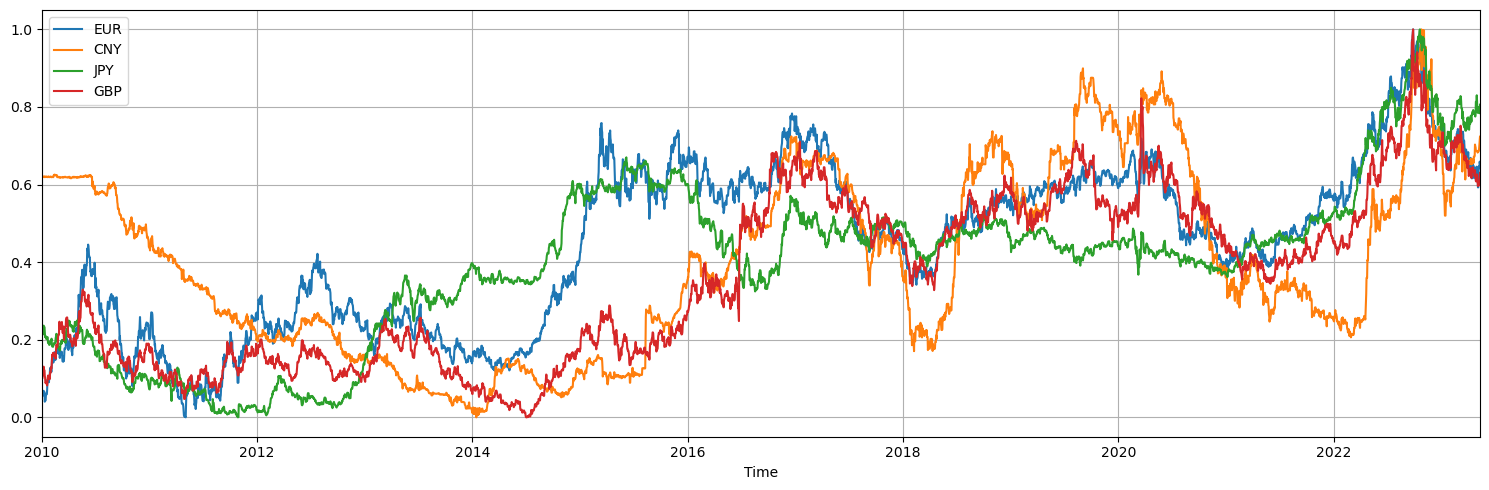

In [6]:
currency_df["date"] = pd.to_datetime(currency_df["date"])

fig, ax = plt.subplots(figsize=(15,5))

for cur in ['EUR', 'CNY', 'JPY', 'GBP']:
    raw_data = currency_df['USD_'+cur]
    normalized = (raw_data - raw_data.min())/(raw_data.max() - raw_data.min())
    ax.plot(currency_df['date'], normalized, label=cur)

ax.set_xlabel('Time')
plt.xlim(currency_df['date'].min(), currency_df['date'].max())
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

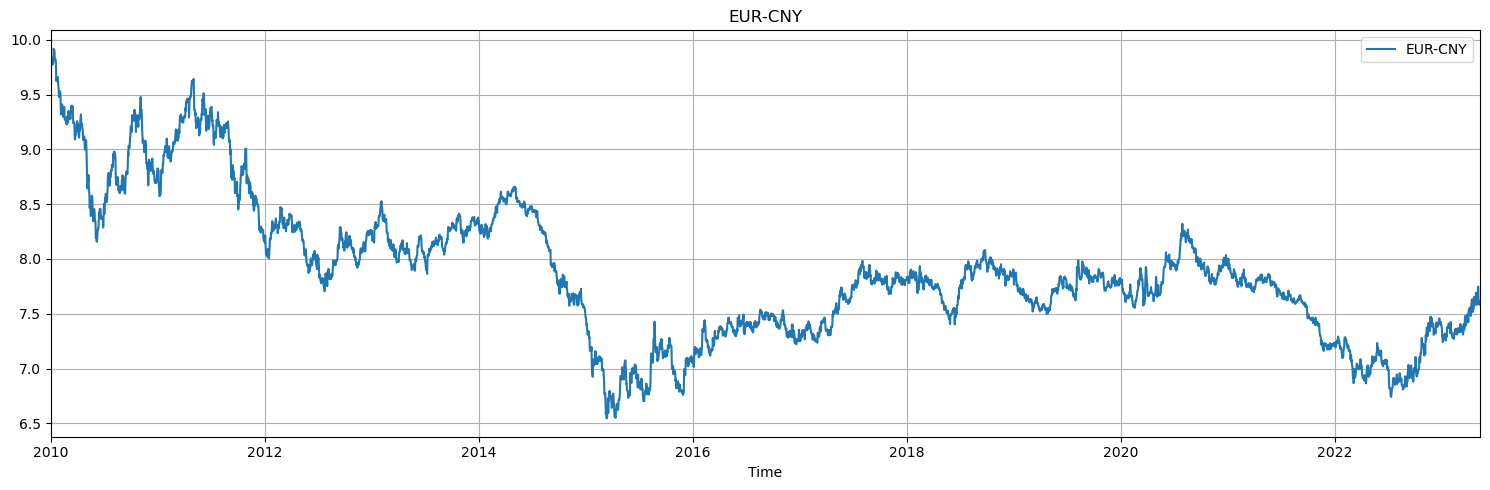

In [40]:
fig, ax = plt.subplots(figsize=(15,5))

raw_data = currency_df['USD_CNY'] / currency_df['USD_EUR'] 
ax.plot(currency_df['date'], raw_data, label="EUR-CNY")

ax.set_xlabel('Time')
plt.xlim(currency_df['date'].min(), currency_df['date'].max())
plt.legend()
plt.grid()
plt.title("EUR-CNY")
plt.tight_layout()
plt.show()

## Get commodity and futures prices

In [7]:
last_date = start_date
# commodity_df = pd.read_sql_query("SELECT * FROM commodity", db_conn)
# if len(commodity_df.index)>0:
#     dates = pd.to_datetime(currency_df['date'])
#     last_date = dates.max()
    
# get oil price
df = quandl.get('OPEC/ORB', start_date=last_date.strftime("%Y-%m-%d"), end_date=date_of_last_friday.strftime("%Y-%m-%d"))
result_df = df.rename(columns={"Value": "OIL"})
result_df.index.names=["date"]

# get gold price
df = quandl.get('LBMA/GOLD', start_date=last_date.strftime("%Y-%m-%d"), end_date=date_of_last_friday.strftime("%Y-%m-%d"))
df.index.names=["date"]
result_df = result_df.join(df[["USD (PM)"]].rename(columns={"USD (PM)": "GOLD"}))

# get silver price
df = quandl.get('LBMA/SILVER', start_date=last_date.strftime("%Y-%m-%d"), end_date=date_of_last_friday.strftime("%Y-%m-%d"))
df.index.names=["date"]
result_df = result_df.join(df[["USD"]].rename(columns={"USD": "SILVER"}))

commodity_df = result_df
commodity_df.to_sql('commodity', db_conn, if_exists='replace')
commodity_df.head(5)


,OIL,GOLD,SILVER
date,,,
2010-01-04,78.23,1121.50,17.17
2010-01-05,79.14,1123.25,17.57
2010-01-06,79.70,1130.00,17.89
2010-01-07,80.19,1130.25,18.09
2010-01-08,79.94,1126.75,18.12


              OIL     GOLD  SILVER
date                              
2010-01-04  78.23  1121.50   17.17
2010-01-05  79.14  1123.25   17.57
2010-01-06  79.70  1130.00   17.89
2010-01-07  80.19  1130.25   18.09
2010-01-08  79.94  1126.75   18.12


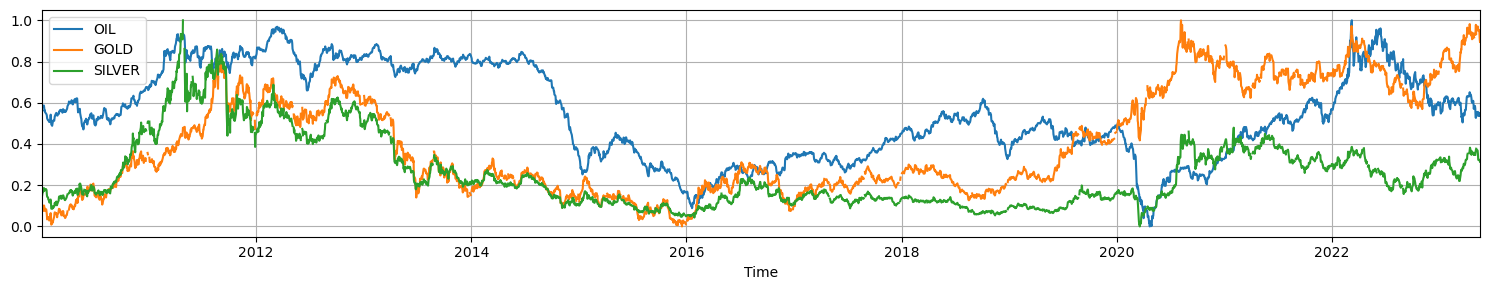

In [8]:
print(commodity_df.head(5))
commodity_df.index = pd.to_datetime(commodity_df.index)

fig, ax = plt.subplots(figsize=(15,3))
for comm in ['OIL', 'GOLD', 'SILVER']:
    raw_data = commodity_df[comm]
    normalized = (raw_data - raw_data.min())/(raw_data.max() - raw_data.min())
    ax.plot(commodity_df.index, normalized, label=comm)

ax.set_xlabel('Time')
plt.xlim(commodity_df.index.min(), commodity_df.index.max())
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## Get interest rates

Get current interest rates:
- United States: Nasdaq / U.S. Treasury [link](https://data.nasdaq.com/data/USTREASURY-us-treasury?utm_campaign=&utm_content=api-for-interest-rate-data&utm_medium=organic&utm_source=google)
- European: Deutsche Bundesbank / European Central Bank [link](https://www.bundesbank.de/en/statistics/money-and-capital-markets/interest-rates-and-yields/ecb-interest-rates-626986)

In [45]:
# api_url = 'https://api.api-ninjas.com/v1/interestrate'
# response = requests.get(api_url, headers={'X-Api-Key': secrets["ninjas-api"]["api-key"]})
# if response.status_code == requests.codes.ok:
#     print(response.text)
# else:
#     print("Error:", response.status_code, response.text)

            US_1month  US_1year  US_2years  EURO
date                                            
2022-11-01       3.56      4.06       4.46  1.50
2022-12-01       3.87      4.22       4.49  2.00
2023-02-01       4.46      4.54       4.65  2.50
2023-03-01       4.52      4.73       4.96  3.00
2023-05-01       4.32      5.10       4.91  3.25


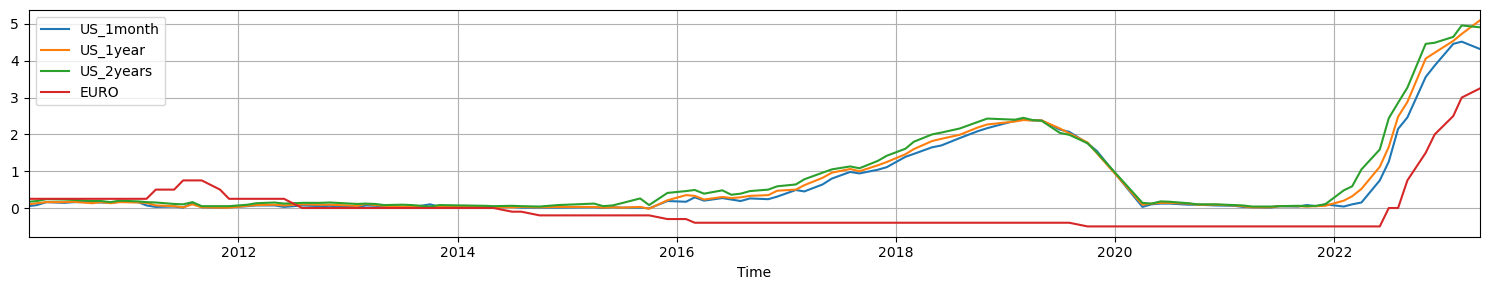

In [35]:
# get US treasury rates
df = quandl.get("USTREASURY/BILLRATES", start_date=last_date.strftime("%Y-%m-%d"), end_date=date_of_last_friday.strftime("%Y-%m-%d"))
df = df[["4 Wk Bank Discount Rate", "13 Wk Bank Discount Rate", "26 Wk Bank Discount Rate"]] \
    .rename(columns={"4 Wk Bank Discount Rate": "US_1month", "13 Wk Bank Discount Rate":"US_1year", "26 Wk Bank Discount Rate":"US_2years"})
df.index.name = "date"

# get European interest rates
response = requests.get("https://api.statistiken.bundesbank.de/rest/download/BBK01/SU0200?format=csv&lang=en")
if response.status_code == requests.codes.ok:
    euro_df = pd.read_csv(StringIO(response.text))
    euro_df.columns =['date', 'EURO', 'Others']
    euro_df.drop(columns=['Others'], inplace=True)
    euro_df['date'] = pd.to_datetime(euro_df['date'], format='%Y-%m-%d', errors='coerce')
    euro_df = euro_df[euro_df['date'].between(last_date.strftime("%Y-%m-%d"), date_of_last_friday.strftime("%Y-%m-%d"))]
    euro_df['EURO'] = euro_df['EURO'].astype('float32')
    euro_df.set_index("date", inplace=True)
    df = df.join(euro_df, how="inner")
else:
    print("Error:", response.status_code, response.text)

print(df.tail(5))

fig, ax = plt.subplots(figsize=(15,3))
with_normalization = False
for comm in ['US_1month', 'US_1year', 'US_2years', 'EURO']:
    raw_data = df[comm]
    if with_normalization:
        normalized = (raw_data - raw_data.min())/(raw_data.max() - raw_data.min())
        ax.plot(df.index, normalized, label=comm)
    else:
        ax.plot(df.index, raw_data, label=comm)

ax.set_xlabel('Time')
plt.xlim(df.index.min(), df.index.max())
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

## Explore stock markets and record symbols for further steps
Get all symbols by countries, indices, industries

In [72]:
from pytickersymbols import PyTickerSymbols

stock_data = PyTickerSymbols()
countries = stock_data.get_all_countries()
indices = stock_data.get_all_indices()
industries = stock_data.get_all_industries()

de_dax_stocks = stock_data.get_stocks_by_index('DAX')
uk_ftse_stocks = stock_data.get_stocks_by_index('FTSE 100')

stock_data.get_all_stocks()[0]

{'name': 'adidas AG',
 'symbol': 'ADS',
 'country': 'Germany',
 'indices': ['DAX', 'EURO STOXX 50'],
 'industries': ['Cyclical Consumer Products',
  'Footwear',
  'Textiles & Apparel',
  'Consumer Cyclicals',
  'Sportswear',
  'Toiletries'],
 'symbols': [{'yahoo': 'ADS.F', 'google': 'FRA:ADS', 'currency': 'EUR'},
  {'yahoo': 'ADDDF', 'google': 'OTCMKTS:ADDDF', 'currency': 'USD'},
  {'yahoo': 'ADDYY', 'google': 'OTCMKTS:ADDYY', 'currency': 'USD'},
  {'yahoo': 'ADS1.F', 'google': 'FRA:ADS1', 'currency': 'EUR'}],
 'metadata': {'founded': 1924, 'employees': 57016},
 'isins': ['DE000A1EWWW0'],
 'akas': []}

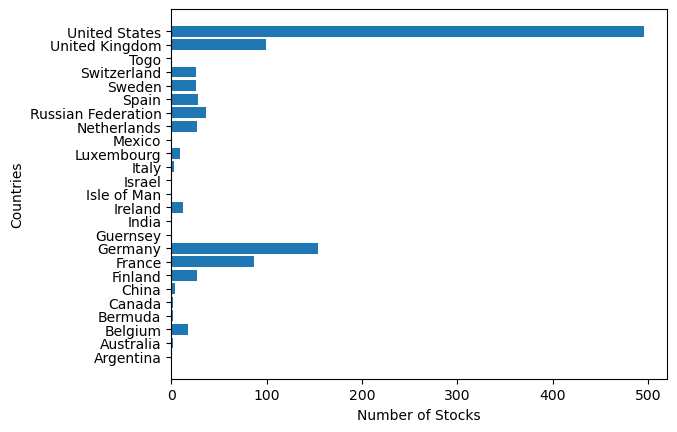

In [74]:
stock_info_df = pd.read_json(json.dumps(stock_data.get_all_stocks()))
stock_info_df.drop(['wiki_name', 'akas'], inplace=True, axis=1)     # remove unused columns
df = stock_info_df.groupby(['country'])['country'].count().reset_index(name="count")

fig, ax = plt.subplots()
y_pos = np.arange(len(df["country"]))
ax.barh(y_pos, df["count"])
ax.set_xlabel('Number of Stocks')
ax.set_yticks(y_pos, labels=df["country"])
ax.set_ylabel('Countries')
plt.show()

Extract all yahoo tickers

In [75]:
yahoo_tickers = stock_info_df.assign(ticker=lambda x: x['symbols'])

# remove stock with empty symbol
yahoo_tickers = yahoo_tickers.drop(yahoo_tickers[yahoo_tickers["ticker"].apply(lambda x: len(x))==0].index)
# extract yahoo symbol
yahoo_tickers["ticker"] = yahoo_tickers["ticker"].apply(lambda x: x[0]['yahoo'])
yahoo_tickers.head(5)

,name,symbol,country,indices,industries,symbols,metadata,isins,ticker
0,adidas AG,ADS,Germany,"[DAX, EURO STOXX 50]","[Cyclical Consumer Products, Footwear, Textile...","[{'yahoo': 'ADS.F', 'google': 'FRA:ADS', 'curr...","{'founded': 1924, 'employees': 57016}",[DE000A1EWWW0],ADS.F
1,Allianz SE,ALV,Germany,"[DAX, EURO STOXX 50]","[Insurance, Financials, Multiline Insurance & ...","[{'yahoo': 'ALV.F', 'google': 'FRA:ALV', 'curr...","{'founded': 1890, 'employees': 147268}",[DE0008404005],ALV.F
2,BASF SE,BAS,Germany,"[DAX, EURO STOXX 50]","[Diversified Chemicals, Basic Materials, Chemi...","[{'yahoo': 'BAS.F', 'google': 'FRA:BAS', 'curr...","{'founded': 1865, 'employees': 117628}",[DE000BASF111],BAS.F
3,Bayer AG,BAYN,Germany,"[DAX, EURO STOXX 50]","[Pharmaceuticals, Pharmaceuticals & Medical Re...","[{'yahoo': 'BAYN.F', 'google': 'FRA:BAYN', 'cu...","{'founded': 1863, 'employees': 103824}",[DE000BAY0017],BAYN.F
4,Beiersdorf AG,BEI,Germany,[DAX],"[Consumer Non-Cyclicals, Personal Products, Pe...","[{'yahoo': 'BEI.F', 'google': 'FRA:BEI', 'curr...","{'founded': 1882, 'employees': 20306}",[DE0005200000],BEI.F


Parse industry and stock list

In [76]:
import yfinance as yf

msft = yf.Ticker("SMEGF") # MSFT, SMEGF
msft.info

{'address1': 'Otto-Hahn-Ring 6',
 'city': 'Munich',
 'zip': '81739',
 'country': 'Germany',
 'phone': '49 89 636 00',
 'website': 'https://www.siemens-energy.com',
 'industry': 'Specialty Industrial Machinery',
 'industryDisp': 'Specialty Industrial Machinery',
 'sector': 'Industrials',
 'longBusinessSummary': 'Siemens Energy AG operates as an energy technology company worldwide. It operates in two segments, Gas and Power; and Siemens Gamesa Renewable Energy. The company provides gas and steam turbines, generators, gas engines, instrumentation and controls, and electrical systems, as well as performance enhancement, maintenance, customer training, and professional consulting services for central and distributed power generation; and transformers, air and gas-insulated switchgears, AC transmission systems, offshore windfarm grid connections, high voltage direct current transmission systems, high voltage substations, digital solutions and components, and other products. It also offers ro

Release all resources

## Prepare Training Data
The training data includes:
- currency rates
- commodity / futures prices
- interest rates
- stock prices

In [ ]:
window_size = 30    # window_size = 30 days
train_data.rolling(window_size)

In [8]:
db_conn.close()